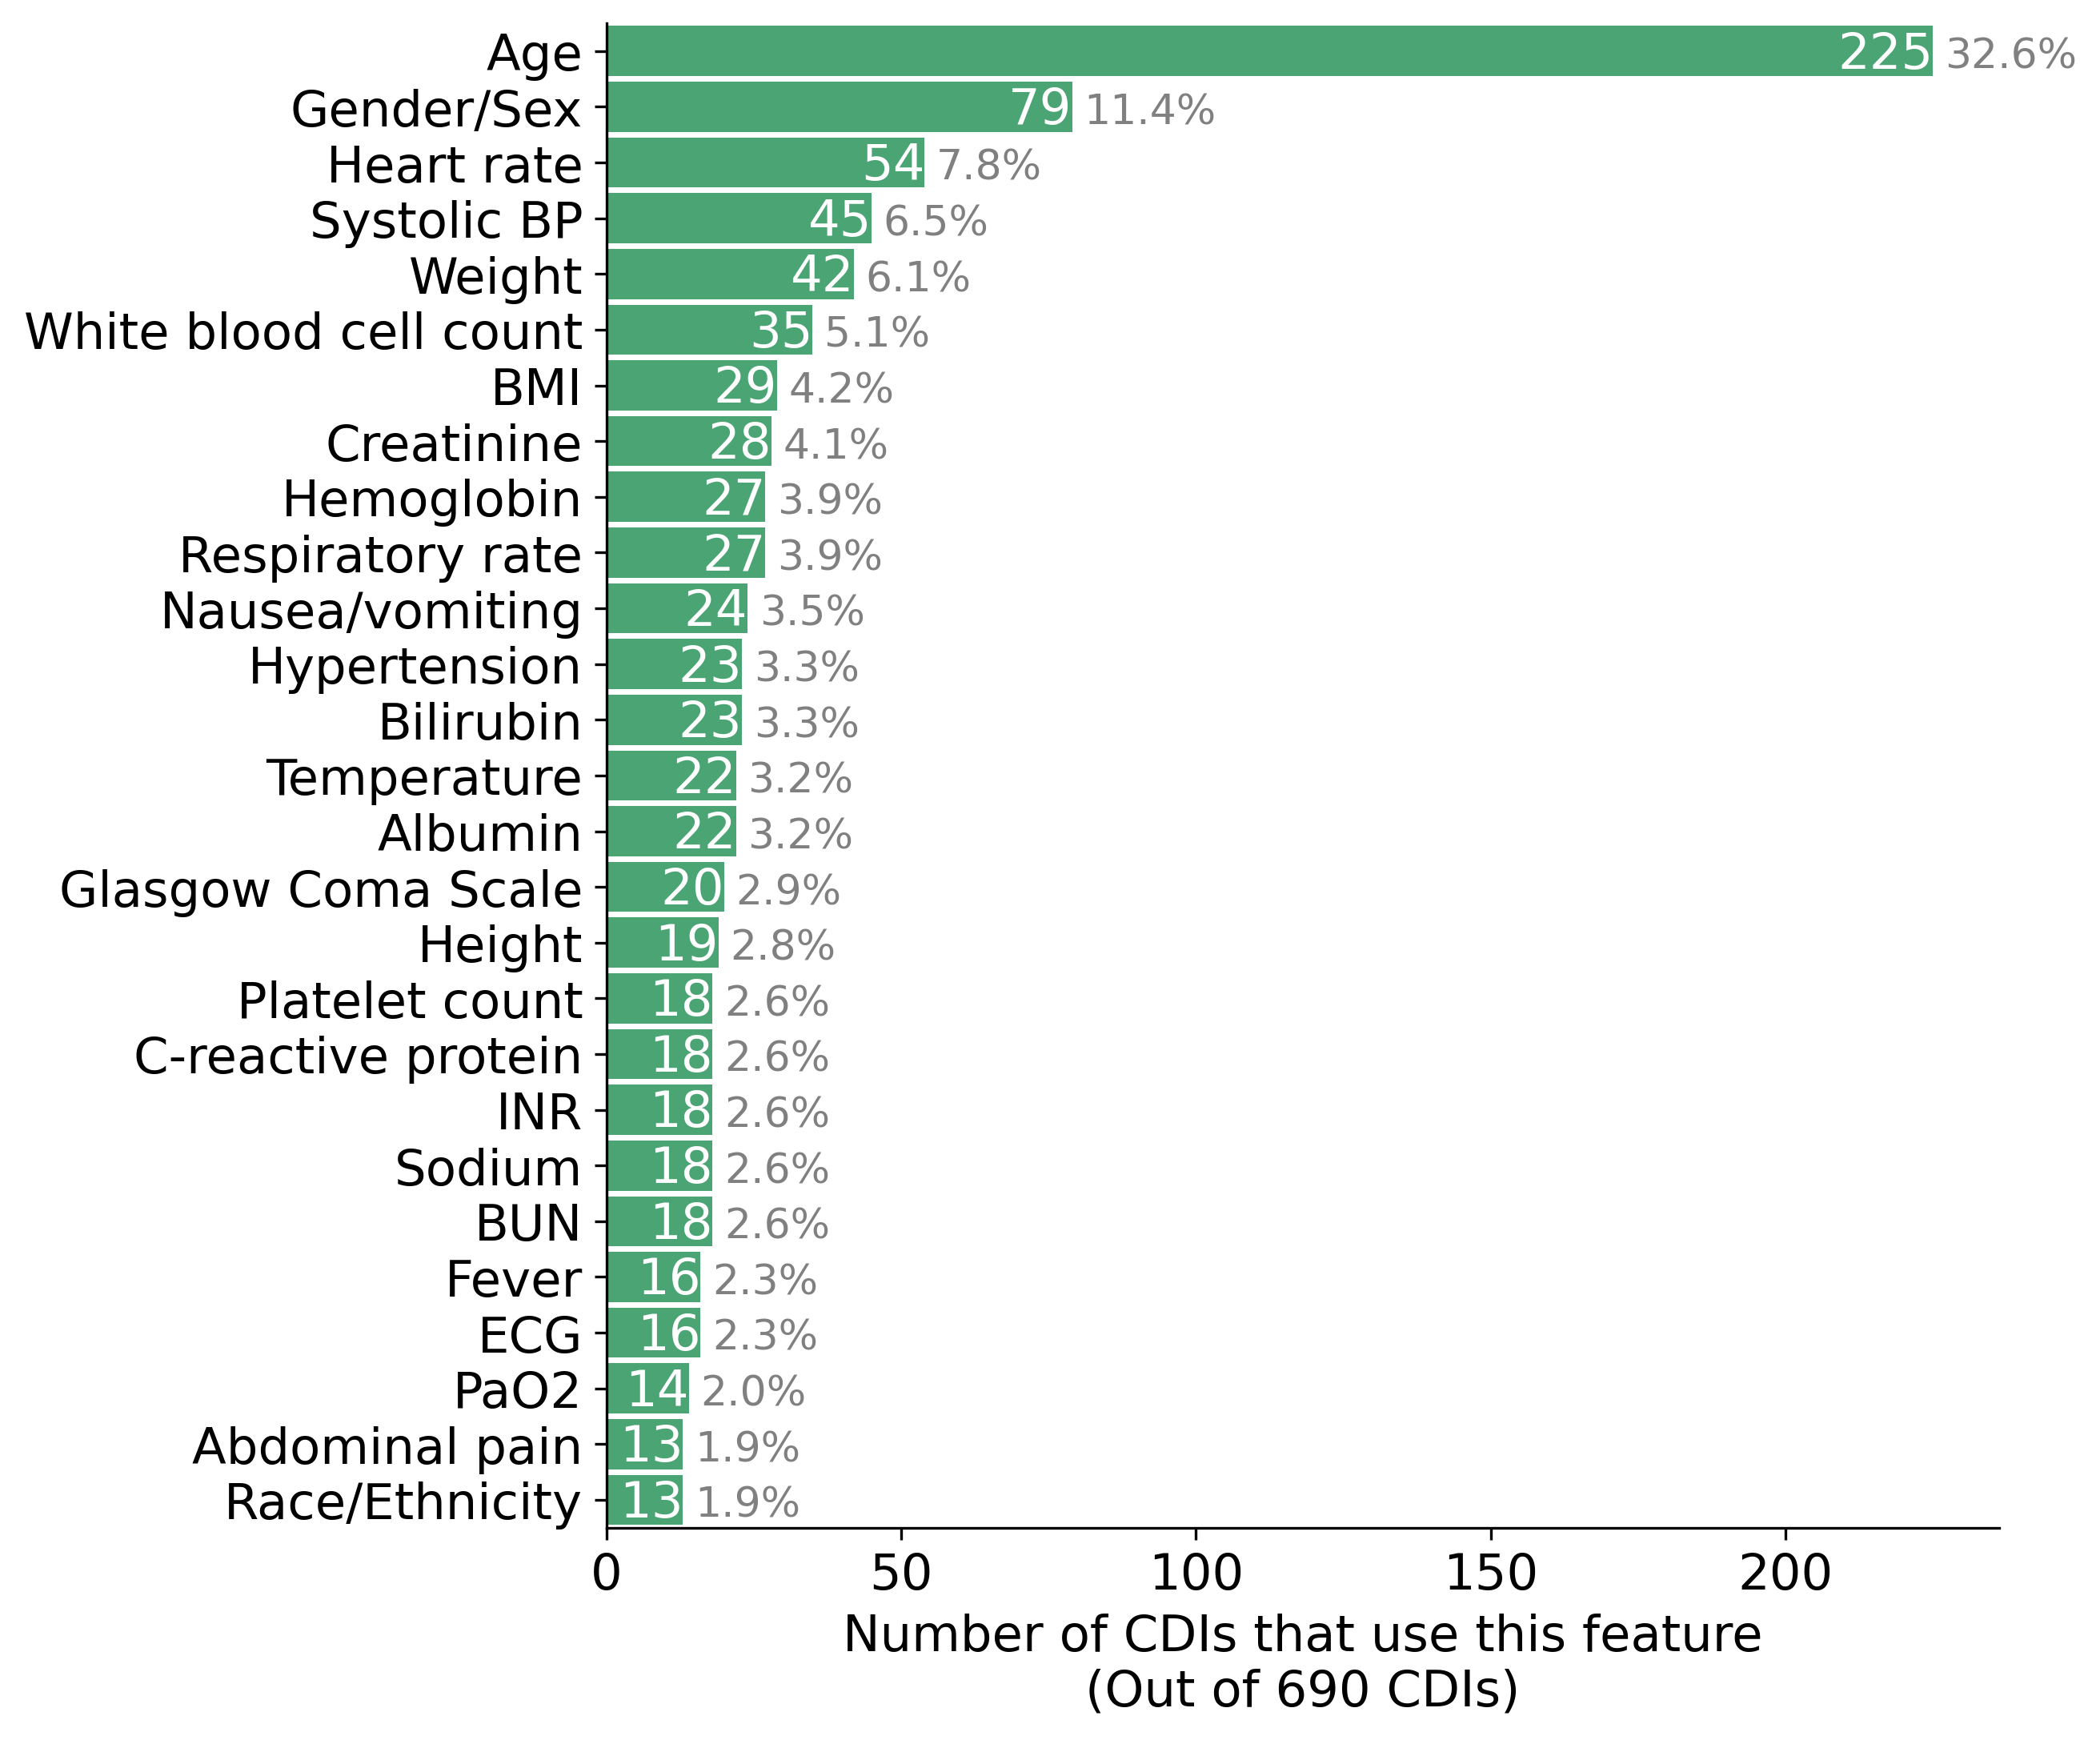

In [1]:
%load_ext autoreload
%autoreload 2


import dvu
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict

import mdcalc
import viz

# plt.style.use('default')
dvu.set_style()

df = pd.read_pickle('../data/cdis_with_schemas_cleaned.pkl')

def get_feature_names_list(schema):
    if isinstance(schema, list):
        return [mdcalc.clean_feature_name(s['label_en']) if 'label_en' in s else 'unknown'
                for s in schema]
    else:
        return []

# these seem to be extra info in the calc, not actually a new feature
def remove_unknown(x):
    return [z for z in x if not z == 'unknown']

df['feature_names'] = df['input_schema'].apply(get_feature_names_list)
df['feature_names'] = df['feature_names'].apply(remove_unknown)
df['feature_names_unique'] = df['feature_names'].apply(
    lambda l: list(set([mdcalc.rename_feature_name(x) for x in l])))

# make plot
all_words = sum(df['feature_names_unique'], [])  # concatenate all list
all_words = pd.Series(all_words)
# all_words = all_words[~(all_words == 'unknown')] # not necessary, already handleed
counts = all_words.value_counts()
feat_names = pd.Series(counts.index)


counts.head(30)
plt.figure(figsize=(9, 7.5), dpi=300, facecolor='w')
N = 27
# plt.grid()
ax = sns.barplot(y=feat_names[:N].apply(lambda x: x[:39]),
                 x=counts.values[:N], orient='h', color='mediumseagreen', width=0.9)
# ax.bar_label(ax.containers[0], fontsize='small')
# bar_label inside of bar
# ax.bar_label(ax.containers[0], fontsize='small', labels=[str(x) + f' ({100 * x/df.shape[0]:.1f}%)' for x in counts.values[:N]])
# add text to each bar
# texts = [str(x) + f' ({100 * x/df.shape[0]:.1f}%)' for x in counts.values[:N]]
texts = [str(x) for x in counts.values[:N]]
for i, p in enumerate(ax.patches):
    ax.annotate(texts[i], (p.get_width(), p.get_y() + 0.75), ha='right', color='white')
texts_perc = [f'{100 * x/df.shape[0]:.1f}%' for x in counts.values[:N]]
for i, p in enumerate(ax.patches):
    ax.annotate(texts_perc[i], (p.get_width() + 2, p.get_y() + 0.75), ha='left', color='gray', fontsize='small')
plt.xlabel(f'Number of CDIs that use this feature\n(Out of {df.shape[0]} CDIs)')
plt.tight_layout()
viz.savefig('common_features')

**Look at the renaming**

In [2]:
feats_print = sorted(set(sum(df['feature_names'], [])))
df_print = pd.DataFrame(feats_print, columns=['Original feature'])
df_print['Chandan rename'] = df_print['Original feature'].apply(mdcalc.rename_feature_name)
idxs_same = df_print['Chandan rename'] == df_print['Original feature']
df_print['Chandan rename'][idxs_same] = ''
df_print.to_csv('../data/renaming/features.csv', index=False)

### Feature counts

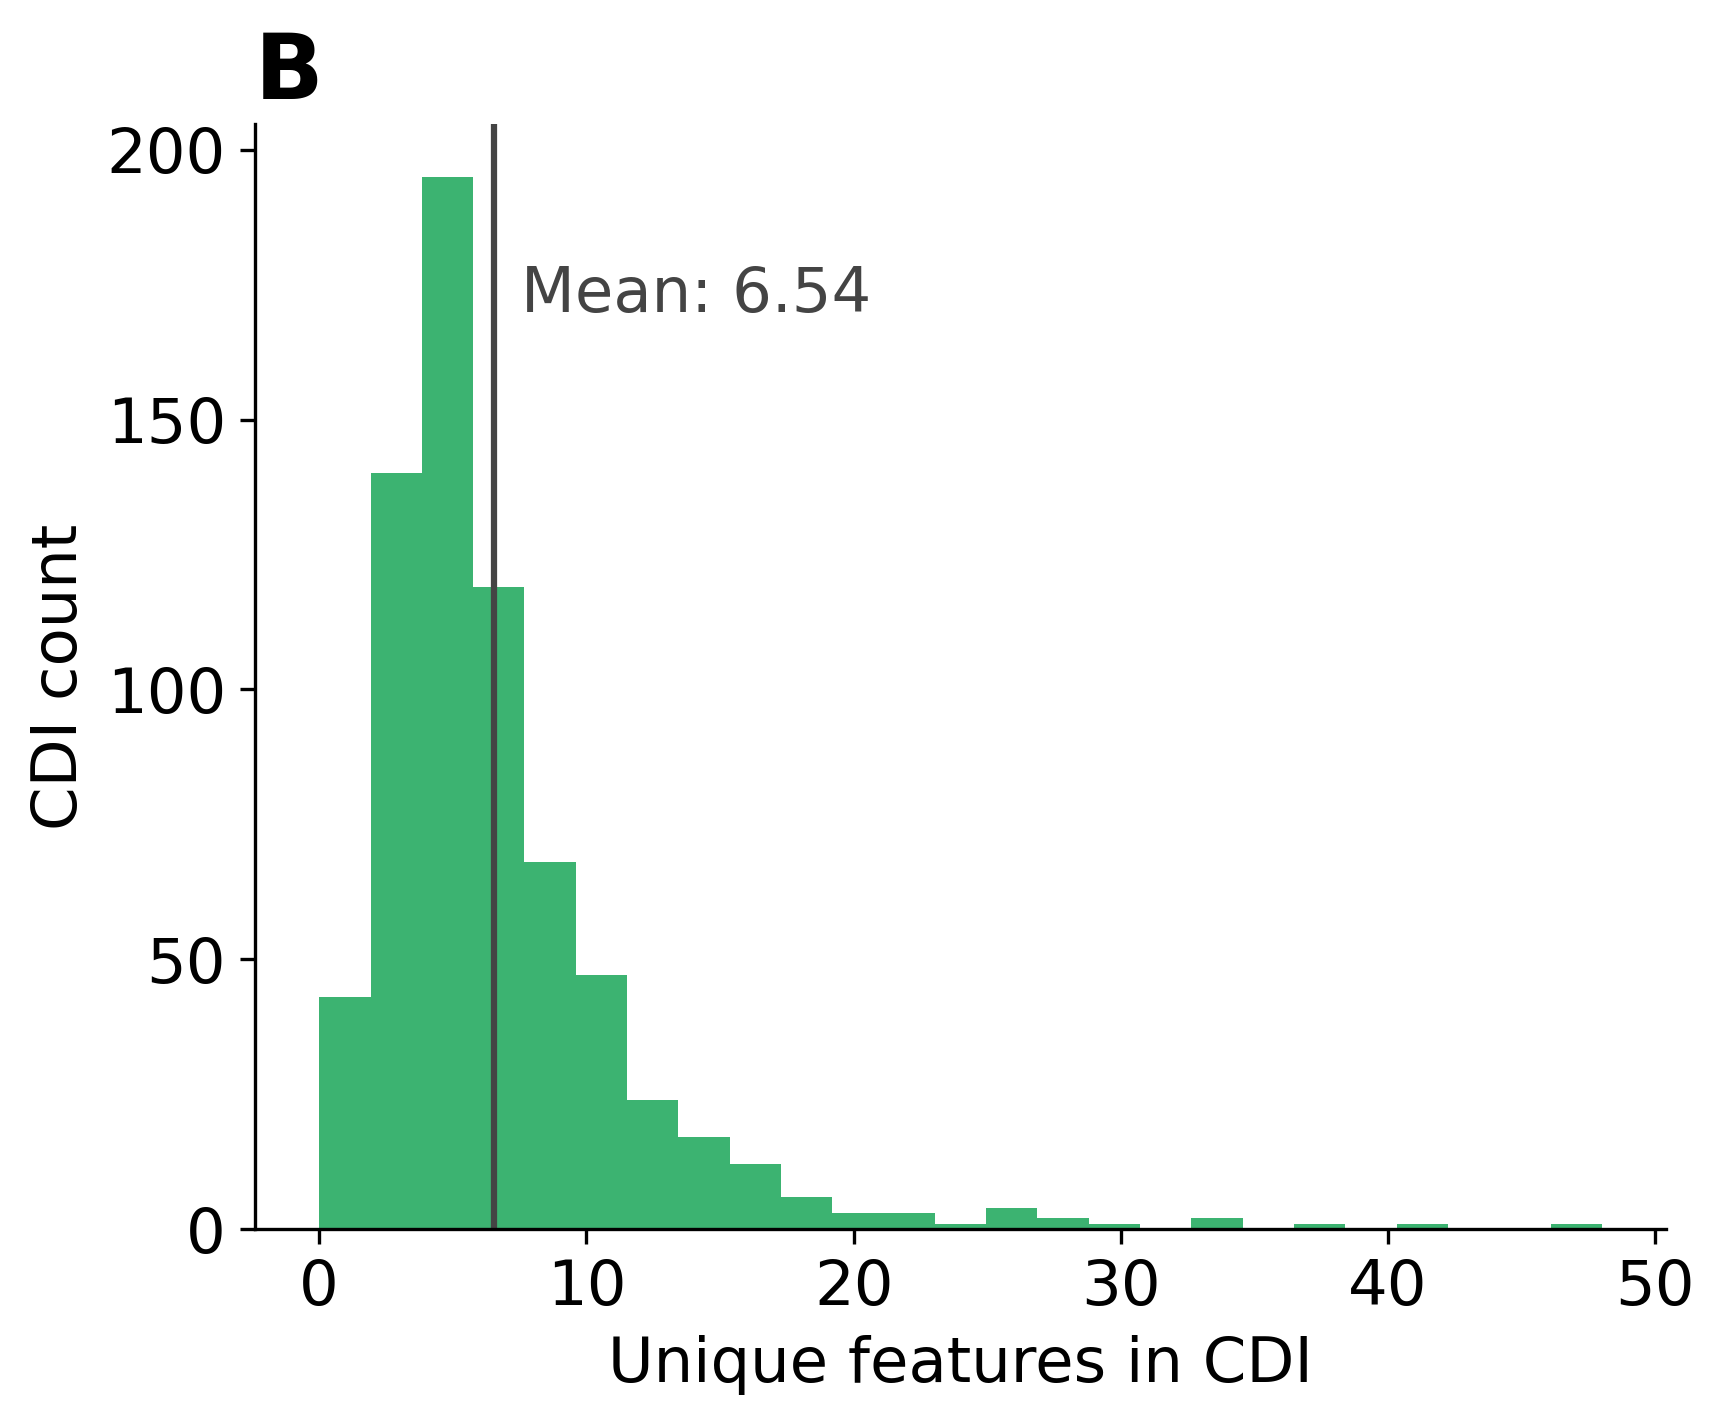

In [3]:
# df['num_splits'] = df['feature_names'].apply(len)
df['num_features_unique'] = df['feature_names_unique'].apply(len)

plt.figure(dpi=300, facecolor='w', figsize=(6, 5))
# plt.hist(df['num_splits'], label='Splits in CDI', bins=25)
avg = np.mean(df['num_features_unique'])
plt.axvline(x=avg, ls='-', color='#444')
plt.text(s=f'Mean: {avg:0.2f}', x=avg + 1, y=170, color='#444')
plt.hist(df['num_features_unique'], label='Unique features in CDI', bins=25, color='mediumseagreen') #, alpha=0.8)
plt.xlabel('Unique features in CDI')
# plt.ylabel(f'Count of CDIs\n(out of {df.shape[0]} CDIs)')
plt.ylabel('CDI count')
plt.title('B', loc='left', fontsize='x-large', fontweight='bold')
plt.tight_layout()

# plt.legend()
viz.savefig('num_rules_hist')
# plt.show()

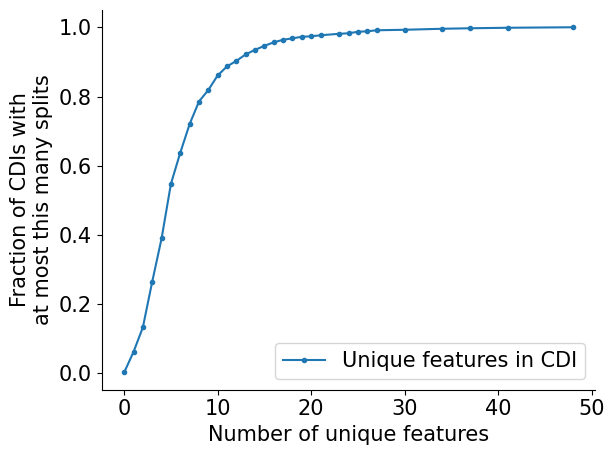

In [4]:
# vals, counts = np.unique(df['num_splits'], return_counts=True)
# plt.plot(vals, np.cumsum(counts) / np.sum(counts), '.-', label='Splits in CDI')
# val_90 = (np.cumsum(counts) / np.sum(counts)) >= 0.9

# plt.show()
vals, counts = np.unique(df['num_features_unique'], return_counts=True)
plt.plot(vals, np.cumsum(counts) / np.sum(counts), '.-', label='Unique features in CDI')

plt.xlabel('Number of unique features')
plt.ylabel('Fraction of CDIs with\nat most this many splits')
plt.legend()
viz.savefig('num_rules_cdf')
plt.show()

# Feature analysis

only keeping 309 CDIs out of 690


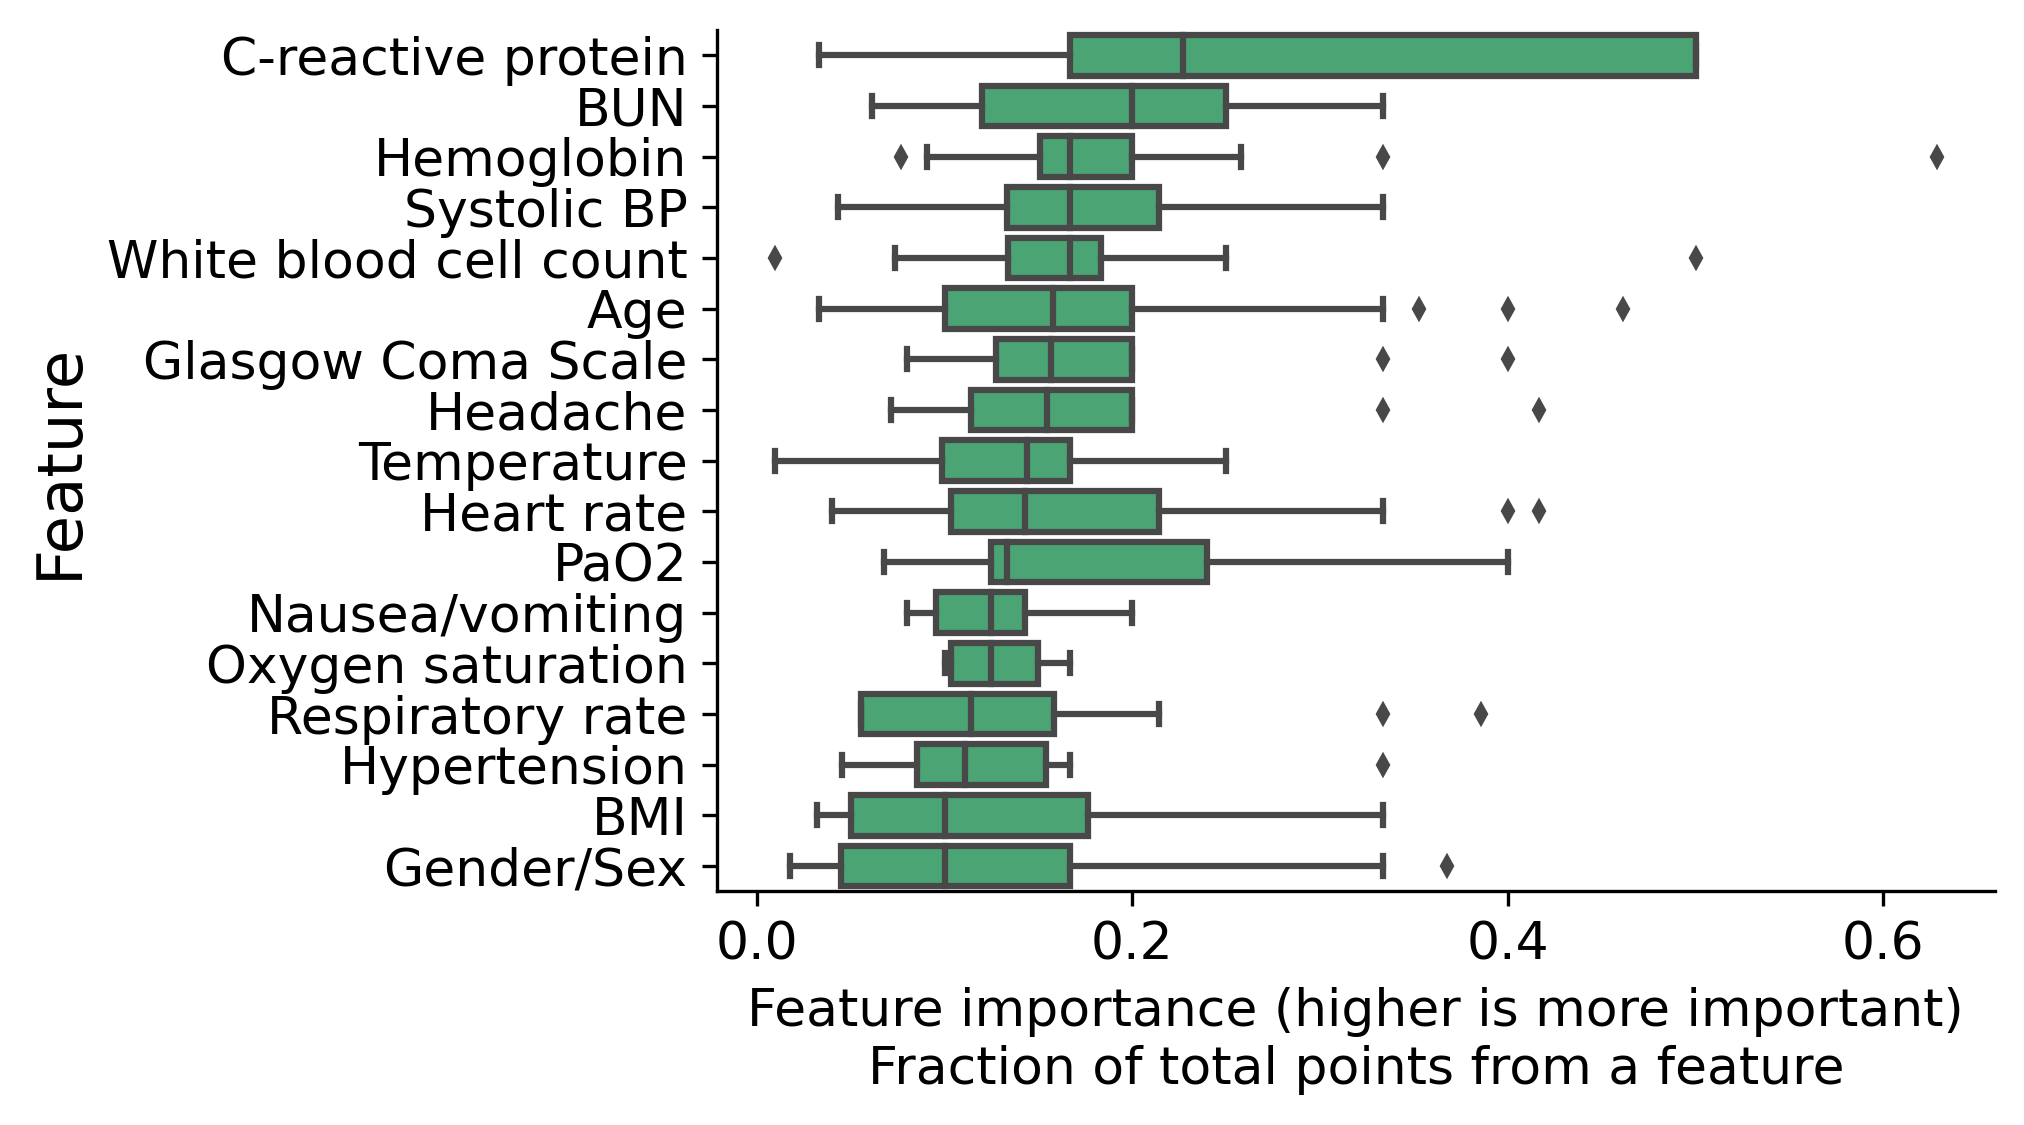

In [7]:
# get scores for each feature
df["feature_names_with_vals"] = df["input_schema"].apply(
    mdcalc.get_feature_score_tuples_list_from_schema
)

# only keep scoring-only CDIs
feature_names_with_vals = df["feature_names_with_vals"][
    df["feature_names_with_vals"].apply(len) > 0
]
print("only keeping", feature_names_with_vals.shape[0], "CDIs out of", df.shape[0])

# get score_dict
score_tuples = sorted(sum(feature_names_with_vals, []), key=lambda x: x[0])
ks = sorted(set([score_tuple[0] for score_tuple in score_tuples]))
score_dict = defaultdict(list)
for key, score in score_tuples:
    score_dict[key].append(score)

# filter list
scores_list = [
    (k, v)
    for (k, v) in score_dict.items()
    if len(v) >= 9
    # or k == 'Race/Ethnicity'
]
# scores_list = sorted(score_dict_filt, key=lambda x: len(x[1]), reverse=True)

# format into df
feat_name_vec = sum([[k] * len(v) for (k, v) in scores_list], [])
score_vec = sum([v for (k, v) in scores_list], [])
df_box = pd.DataFrame.from_dict({"feat_name": feat_name_vec, "score": score_vec})
medians = df_box.groupby(["feat_name"])["score"].median().sort_values(ascending=False)

# plot
plt.figure(dpi=300, figsize=(7, 4))
# place grid in background behind other elements
sns.boxplot(
    x="score",
    y="feat_name",
    data=df_box,
    color="mediumseagreen",
    order=medians.index,
    fliersize=3.1,
    whis=1.5,

    # change color of fliers
    # flierprops=dict(alpha=1, marker='o', color='#EEE'),
)
plt.ylabel("Feature")
plt.yticks(fontsize="small")
plt.xticks(fontsize="small")
plt.xlabel(
    "Feature importance (higher is more important)\nFraction of total points from a feature",
    fontsize="small",
)
# plt.grid(axis="x")
plt.tight_layout()
viz.savefig("scoring_cdi_boxplot")

# Feature debugging

In [2]:
d = pd.read_pickle('../data/cdis_with_schemas_cleaned.pkl')

In [8]:
# example debugging schema
x = d[d.slug == 'cha2ds2-vasc-score-atrial-fibrillation-stroke-risk'].iloc[0]
schema = x['input_schema']
schema
for s in schema:
    options = s['options']
    print(s['name'], mdcalc.clean_feature_name(s['label_en']), [opt['value'] for opt in options])

age Age [0, 1, 2]
sex Sex [1, 0]
heart_failure CHF history [0, 1]
hypertension Hypertension history [0, 1]
stroke Stroke/TIA/thromboembolism history [0, 2]
vascular_disease Vascular disease history (prior MI, peripheral artery disease, or aortic plaque) [0, 1]
diabetes Diabetes history [0, 1]


In [14]:
print(schema)

[{'type': 'radio', 'label_en': '<p>Age</p>', 'name': 'age', 'default': None, 'show_points': True, 'optional': False, 'conditionality': '', 'tips_en': '', 'options': [{'label': '<65', 'value': 0}, {'label': '65-74', 'value': 1}, {'label': '≥75', 'value': 2}]}, {'type': 'toggle', 'name': 'sex', 'conditionality': '', 'optional': False, 'default': None, 'label_en': '<p>Sex</p>', 'show_points': True, 'tips_en': '', 'options': [{'label': 'Female', 'value': 1}, {'label': 'Male', 'value': 0}]}, {'type': 'toggle', 'name': 'heart_failure', 'conditionality': '', 'optional': False, 'default': 0, 'label_en': '<p><abbr title="Congestive heart failure">CHF</abbr> history</p>', 'show_points': True, 'tips_en': '', 'options': [{'label': 'No', 'value': 0}, {'label': 'Yes', 'value': 1}]}, {'type': 'toggle', 'name': 'hypertension', 'conditionality': '', 'optional': False, 'default': 0, 'label_en': '<p>Hypertension history</p>', 'show_points': True, 'tips_en': '', 'options': [{'label': 'No', 'value': 0}, {'

In [45]:
display(df[df["feature_names_with_vals"].apply(len) == 2].iloc[3][['url_full', 'input_schema']])

url_full        https://www.mdcalc.com/calc/3837/modified-fish...
input_schema    [{'type': 'radio', 'name': 'crp', 'default': N...
Name: 377, dtype: object

In [11]:
# display full
with pd.option_context("display.max_colwidth", 1000):
    display(df[df["feature_names_with_vals"].apply(len) == 2][['url_full', 'feature_names_unique', 'input_schema']])

,url_full,feature_names_with_vals,input_schema
662,https://www.mdcalc.com/calc/2045/urine-anion-gap,"[(Wheals, 0.5), (Pruritus, 0.5)]","[{'type': 'radio', 'label_en': 'Wheals', 'default': 0, 'conditionality': '', 'show_points': True, 'tips_en': '', 'optional': False, 'options': [{'label': 'None', 'value': 0}, {'label': 'Mild (<20 wheals/24 hrs)', 'value': 1}, {'label': 'Moderate (20-50 wheals/24 hrs)', 'value': 2}, {'label': 'Intense (>50 wheals/24 hrs or large confluent areas of wheals)', 'value': 3}], 'name': 'wheals'}, {'type': 'radio', 'label_en': 'Pruritus', 'default': 0, 'conditionality': '', 'show_points': True, 'tips_en': '', 'optional': False, 'options': [{'label': 'None', 'value': 0}, {'label': 'Mild (present but not annoying or troublesome)', 'value': 1}, {'label': 'Moderate (troublesome but does not interfere with normal daily activity or sleep)', 'value': 2}, {'label': ' Intense (severe, interferes with normal daily activity or sleep)', 'value': 3}], 'name': 'pruritus'}]"
248,https://www.mdcalc.com/calc/3311/glasgow-prognostic-score-gps-cancer-outcomes,"[(C-reactive protein, 0.5), (Albumin, 0.5)]","[{'type': 'radio', 'label_en': 'CRP', 'default': None, 'conditionality': '', 'show_points': False, 'tips_en': '', 'optional': False, 'options': [{'label': 'CRP ≤10 mg/L', 'value': 1}, {'label': 'CRP >10 mg/L', 'value': 2}], 'name': 'crp'}, {'type': 'radio', 'label_en': 'Albumin', 'default': None, 'conditionality': '', 'show_points': False, 'tips_en': '', 'optional': False, 'options': [{'label': 'Albumin <3.5 g/dL (35 g/L)', 'value': 1}, {'label': 'Albumin ≥3.5 g/dL (35 g/L)', 'value': 2}], 'name': 'alb'}]"
490,https://www.mdcalc.com/calc/3385/prevention-incidence-asthma-mite-allergy-piama-risk-score,"[(C-reactive protein, 0.5), (White blood cell count, 0.5)]","[{'type': 'radio', 'name': 'crp', 'default': None, 'show_points': False, 'optional': False, 'conditionality': None, 'tips_en': '', 'label_en': 'CRP', 'option_fhir_rules': None, 'options': [{'label': 'CRP ≤10 mg/L', 'value': 0}, {'label': 'CRP >10 mg/L', 'value': 1}], 'mdcalc_info_concept': None}, {'type': 'radio', 'name': 'wbc', 'default': None, 'show_points': False, 'optional': False, 'conditionality': None, 'tips_en': '', 'label_en': 'White blood cell count', 'option_fhir_rules': None, 'options': [{'label': 'WBC ≤ 11 x 10⁹/L', 'value': 0}, {'label': 'WBC > 11 x 10⁹/L', 'value': 1}], 'mdcalc_info_concept': None}]"
377,https://www.mdcalc.com/calc/3837/modified-fisher-grading-scale-subarachnoid-hemorrhage-sah,"[(C-reactive protein, 0.5), (Albumin, 0.5)]","[{'type': 'radio', 'name': 'crp', 'default': None, 'show_points': False, 'optional': False, 'conditionality': '', 'tips_en': '', 'label_en': 'CRP', 'option_fhir_rules': None, 'options': [{'label': 'CRP ≤10 mg/L', 'value': 1}, {'label': 'CRP >10 mg/L', 'value': 2}], 'mdcalc_info_concept': None}, {'type': 'radio', 'name': 'alb', 'default': None, 'show_points': False, 'optional': False, 'conditionality': '', 'tips_en': '', 'label_en': 'Albumin', 'option_fhir_rules': None, 'options': [{'label': 'Albumin <3.5 g/dL (35 g/L)', 'value': 1}, {'label': 'Albumin ≥3.5 g/dL (35 g/L)', 'value': 2}], 'mdcalc_info_concept': None}]"
141,https://www.mdcalc.com/calc/3903/cardiac-anesthesia-risk-evaluation-score-care,"[(Patient status, 0.8), (Emergency: surgery as soon as diagnosis is made and operating room is available, 0.2)]","[{'type': 'radio', 'label_en': 'Patient status', 'name': 'care', 'default': None, 'show_points': True, 'optional': False, 'conditionality': '', 'tips_en': '', 'options': [{'label': 'Stable cardiac disease, no other medical problems, undergoing noncomplex surgery', 'value': 1}, {'label': 'Stable cardiac disease, one or more controlled medical problems, undergoing noncomplex surgery', 'value': 2}, {'label': 'Any uncontrolled medical problem OR undergoing complex surgery', 'value': 3}, {'label': 'Any uncontrolled medical problem AND undergoing complex surgery', 'value': 4}, {'label': 'Chronic or advanced cardia